# Import data and create datasets

In [1]:
from sklearn.neighbors import NearestNeighbors
from metric_learn import MMC_Supervised
from metric_learn import Covariance
from metric_learn import LMNN
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.io import loadmat
from collections import Counter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
%matplotlib inline

In [2]:
with open('feature_data.json', 'r') as f:
    features = json.load(f)

In [3]:
mat = loadmat('cuhk03_new_protocol_config_labeled.mat')

camId = mat['camId'].flatten()
filelist = mat['filelist'].flatten()
labels = mat['labels'].flatten()
train_idx = mat['train_idx'].flatten()
query_idx = mat['query_idx'].flatten()
gallery_idx = mat['gallery_idx'].flatten()

del mat

print(camId.shape)
print(filelist.shape)
print(labels.shape)
print(query_idx.shape)
print(train_idx.shape)
print(gallery_idx.shape)

(14096,)
(14096,)
(14096,)
(1400,)
(7368,)
(5328,)


In [4]:
features = np.array(features)
features.shape

(14096, 2048)

In [5]:
X_train = features[train_idx-1]
Y_train = labels[train_idx-1]
X_query = features[query_idx-1]
Y_query = labels[query_idx-1]
X_gallery = features[gallery_idx-1]
Y_gallery = labels[gallery_idx-1]
print(X_train.shape)
print(Y_train.shape)
print(X_query.shape)
print(Y_query.shape)
print(X_gallery.shape)
print(Y_gallery.shape)
del features

(7368, 2048)
(7368,)
(1400, 2048)
(1400,)
(5328, 2048)
(5328,)


In [6]:
gc.collect()

0

# Tools
## To compute and evaluate

In [7]:
def get_global_idxs(neighbors):
    # This function also clean-up the neighbors, deleting those from the same camera for the same person
    return [(query_idx[i]-1, [j-1 for j in gallery_idx[neighbors_idxs] 
                          if not (camId[j-1] == camId[query_idx[i]-1] and labels[j-1] == labels[query_idx[i]-1])]) 
            for i, neighbors_idxs in enumerate(neighbors)]
def compute_success(global_idxs_list):
    return [[labels[query_id] == labels[neigh_id] for neigh_id in neigh_ids] 
            for (query_id, neigh_ids) in global_idxs_list]
def compute_ranks(success_list):
    return np.mean([[True in results[:i+1] for i in range(10)] for results in success_list], axis=0)
def compute_map10(success_list):
    # This compute the area under the precision vs recall curve using trapezoidal approx (not rect)
    #(https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)
    p_r_list = np.array([[[sum(success[:i+1])/(i+1), sum(success[:i+1])/sum(success[:10])] for i in range(10)]
           for success in success_list ])
    return np.mean([np.trapz(np.concatenate(([1],p_r[:,0])), np.concatenate(([0], p_r[:,1]))) for p_r in p_r_list])
def print_metrics(ranks, mAP="??"):
    print("@rank1: {:f}, @rank5: {:f}, @rank10: {:f}, mAP: {}".format(ranks[0], ranks[4], ranks[9], mAP))
def compute_and_print(global_idxs):
    success = compute_success(global_idxs)
    ranks = compute_ranks(success)
    mAP = compute_map10(success)
    print_metrics(ranks, mAP)
    return ranks, mAP
def rank(transformer, knn_param={}):
    X_gallery_transformed = transformer.transform(X_gallery)
    X_query_transformed = transformer.transform(X_query)
    knn = NearestNeighbors(n_neighbors=40, **knn_param)
    knn.fit(X_gallery_transformed)
    neighbors = knn.kneighbors(X_query_transformed, return_distance=False)
    neighbors = np.array(neighbors)
    global_idxs = get_global_idxs(neighbors)
    ranks, mAP = compute_and_print(global_idxs)
    return global_idxs, ranks, mAP
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, input_array, y=None):
        return self
    def transform(self, input_array, y=None):
        return input_array*1

## To display gallery

In [8]:
def frame_image(img, color="b"):
    # This function add a colored border to the source image
    b = 5
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb
        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]))
        if color=='g': framed_img[:,:,1] = 1.0
        elif color=='r': framed_img[:,:,0] = 1.0
    else: assert False
    framed_img[b:-b, b:-b] = img
    return framed_img
def plot_gallery(global_idxs_list):
    success = compute_success(global_idxs_list)
    plt.figure(figsize=(15, len(global_idxs_list) * 3))
    for i, (query_id, neigh_ids) in enumerate(global_idxs_list):
        plt.subplot(len(global_idxs_list), 11, (11*i)+1)
        img = mpimg.imread('images_cuhk03/' + filelist[query_id][0])
        plt.imshow(frame_image(img, 'b'), interpolation='none', aspect='auto')
        plt.axis('off')
        for j in range(10):
            plt.subplot(len(global_idxs_list), 11, (11*i)+j+2)
            img = mpimg.imread('images_cuhk03/' + filelist[neigh_ids[j]][0])
            plt.imshow(frame_image(img, 'g' if success[i][j] else 'r'), interpolation='none', aspect='auto')
            plt.axis('off')
    plt.show()

# Baseline : kNN only

In [17]:
global_idxs_base, rank_base, mAP_base = rank(IdentityTransformer())

@rank1: 0.470000, @rank5: 0.668571, @rank10: 0.749286, mAP: 0.5068991165910809


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Same as lecturer, except for mAP

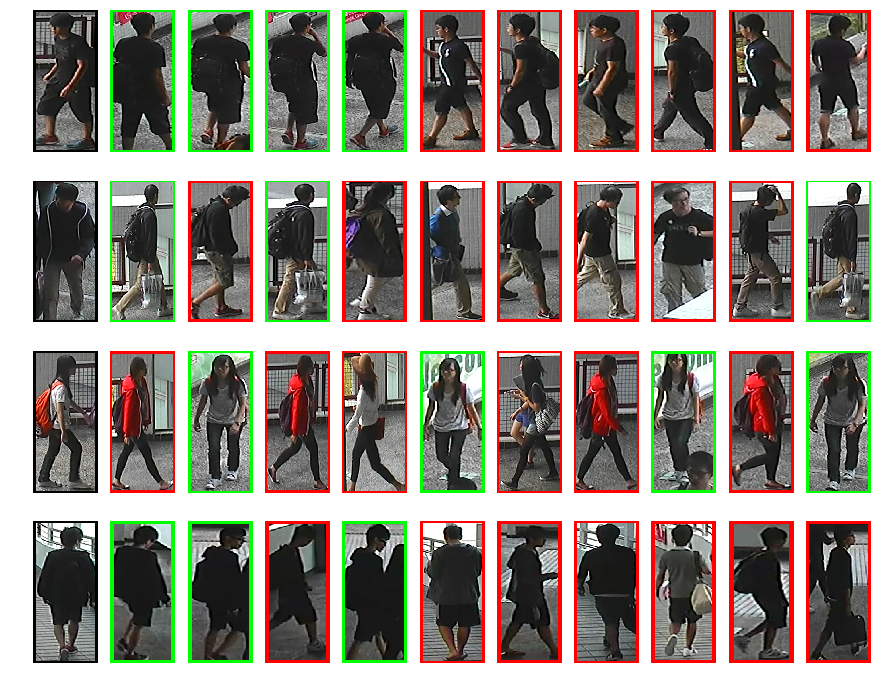

In [19]:
ids_to_show = np.random.randint(0, len(global_idxs_base)+1, size=4)
plot_gallery([global_idxs_base[i] for i in ids_to_show])

# kNN after PCA

In [13]:
pca = PCA(n_components=500, whiten=True).fit(X_train)

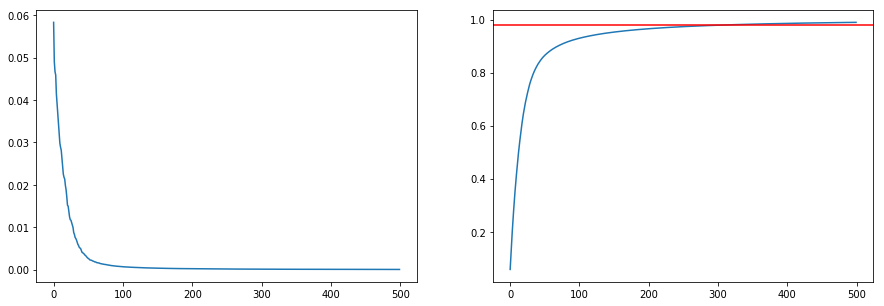

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.98,color='red')

In [20]:
global_idxs_pca, ranks_pca, mAP_pca = rank(pca)

@rank1: 0.381429, @rank5: 0.588571, @rank10: 0.670000, mAP: 0.43140643896447467


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


PCA only cannot separate clusters. We need to improve the margins.

# kNN after LDA 

In [22]:
lda = LinearDiscriminantAnalysis().fit(X_train, Y_train)

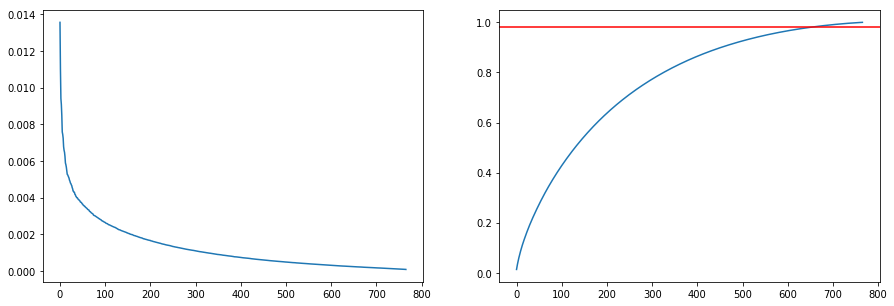

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(lda.explained_variance_ratio_)
plt.subplot(1,2,2)
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.axhline(y=0.98,color='red')

In [24]:
global_idxs_lda, ranks_lda, mAP_lda = rank(lda)

@rank1: 0.421429, @rank5: 0.621429, @rank10: 0.717143, mAP: 0.4662269463340892


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LDA is better than PCA but still worst than raw features.

# k-means baseline
Here we first compute the 700 clusters (there are 700 persons in the gallery dataset). 
For each cluster, we sort the points by their distance to the centroid.
For an image query, we first find the nearest 5 clusters (using a kNN and the cluster's centroid), then we take the points in these clusters, sorted by distance to their cluster's centroid.

In [11]:
def rank_kmean(transformer, kmean_param={}):
    nb_clusters = 700 # nb_samples / mean_nb_person
    X_gallery_transformed = transformer.transform(X_gallery)
    X_query_transformed = transformer.transform(X_query)
    kmeans = KMeans(n_clusters=nb_clusters, random_state=0, **kmean_param)
    kmeans.fit(X_gallery_transformed)
    clusters = [[idx for idx, j in enumerate(kmeans.labels_) if j == i] for i in range(nb_clusters)]
    distance_centroid = [[np.linalg.norm(kmeans.cluster_centers_ - X_gallery_transformed[p_id]) for p_id in cluster]
                         for c_id, cluster in enumerate(clusters)]
    ordered_clusters = [np.array(cluster)[np.argsort(distance_centroid[c_id])] 
                        for c_id, cluster in enumerate(clusters)]
    knn_cluster = NearestNeighbors(n_neighbors=5).fit(kmeans.cluster_centers_)
    nearest_clusters = knn_cluster.kneighbors(X_query_transformed, return_distance=False)
    neighbors = [[idx for cluster_id in c for idx in ordered_clusters[cluster_id]] for c in nearest_clusters]
    global_idxs = get_global_idxs(neighbors)
    success = compute_success(global_idxs)
    ranks, mAP = compute_and_print(global_idxs)
    silhouette = silhouette_score(X_gallery_transformed, kmeans.labels_, metric='euclidean')
    print("Silhouette : ", silhouette)
    return global_idxs, ranks, mAP

In [80]:
global_idxs_base_kmean, ranks_base_kmean, mAP_base_kmean = rank_kmean(IdentityTransformer())

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


@rank1: 0.375714, @rank5: 0.564286, @rank10: 0.660000, mAP: 0.4581236772486772
Silhouette :  0.22658268755992167


# Naive distance benchmark
By naive, I mean not learnt...

In [10]:
mahalanobis_cov = Covariance().fit(X_train)
param_grid = [
    (IdentityTransformer(), {'metric': 'minkowski','p': 2}),    # L2
    (IdentityTransformer(), {'metric': 'correlation'}),
    (IdentityTransformer(), {'metric': 'cosine'}), 
    (mahalanobis_cov, {}) # This is a dummy Mahalanobis distance based on data covariance
]
benchmark_results = []
for (transformer, params) in param_grid:
    benchmark_results.append(rank(transformer, params))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


@rank1: 0.470000, @rank5: 0.668571, @rank10: 0.749286, mAP: 0.5068991165910809


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


@rank1: 0.469286, @rank5: 0.663571, @rank10: 0.742857, mAP: 0.5040293367346939


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


@rank1: 0.475714, @rank5: 0.670000, @rank10: 0.750714, mAP: 0.5102005149281935
@rank1: 0.309286, @rank5: 0.455000, @rank10: 0.501429, mAP: 0.3381757133408919


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# MMC after PCA
[See this paper](http://papers.nips.cc/paper/2164-distance-metric-learning-with-application-to-clustering-with-side-information.pdf)
[and this GitHub](https://github.com/metric-learn/metric-learn)

We cannot train the distance on the raw dataset because it's too large. We have to reduce the number of features. We noticed that PCA+kNN isn't better than kNN on raw data. Let's see if the distance training overcome the loss of information due to PCA.
## Diagonal A

In [37]:
pipe_mmc_pca = Pipeline([('pca', PCA(n_components=300, whiten=True)), 
                         ('mmc', MMC_Supervised(num_constraints=50000, diagonal=True))])
pipe_mmc_pca.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/metric_learn/constraints.py:62: UserWarning: Only generated 49222 positive constraints (requested 50000)
  len(ab), 'positive' if same_label else 'negative', num_constraints))


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('mmc', MMC_Supervised(A0=None, convergence_threshold=1e-06, diagonal=True,
        diagonal_c=1.0, max_iter=100, max_proj=10000,
        num_constraints=50000, num_labeled=inf, verbose=False))])

In [38]:
global_idxs_mmc_pca, ranks_mmc_pca, mAP_mmc_pca = rank(pipe_mmc_pca)

@rank1: 0.441429, @rank5: 0.642143, @rank10: 0.727143, mAP: 0.48210367063492054


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Full A

In [ ]:
pipe_mmc_pca_full = Pipeline([('pca', PCA(n_components=300, whiten=True)), 
                         ('mmc', MMC_Supervised(num_constraints=200, diagonal=False))])
pipe_mmc_pca_full.fit(X_train, Y_train) 

In [ ]:
global_idxs_mmc_pca_full, ranks_mmc_pca_full, mAP_mmc_pca_full = rank(pipe_mmc_pca_full)

# MMC after LDA
[See this paper](http://papers.nips.cc/paper/2164-distance-metric-learning-with-application-to-clustering-with-side-information.pdf)
[and this GitHub](https://github.com/metric-learn/metric-learn)

We cannot train the distance on the raw dataset because it's too large. We have to reduce the number of features. We noticed that PCA+kNN isn't better than kNN on raw data. Let's see if the distance training overcome the loss of information due to PCA.
## Diagonal A

In [11]:
pipe_mmc_lda = Pipeline([('lda', LinearDiscriminantAnalysis()), 
                         ('mmc', MMC_Supervised(num_constraints=10000, diagonal=True))])
pipe_mmc_lda.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('mmc', MMC_Supervised(A0=None, convergence_threshold=1e-06, diagonal=True,
        diagonal_c=1.0, max_iter=100, max_proj=10000,
        num_constraints=10000, num_labeled=inf, verbose=False))])

In [12]:
global_idxs_mmc_lda, ranks_mmc_lda, mAP_mmc_lda = rank(pipe_mmc_lda)

@rank1: 0.424286, @rank5: 0.625714, @rank10: 0.707143, mAP: 0.4655589096749811


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### rLDA

In [16]:
pipe_mmc_rlda = Pipeline([('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')), 
                         ('mmc', MMC_Supervised(num_constraints=20000, diagonal=True))])
pipe_mmc_rlda.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='eigen', store_covariance=False, tol=0.0001)), ('mmc', MMC_Supervised(A0=None, convergence_threshold=1e-06, diagonal=True,
        diagonal_c=1.0, max_iter=100, max_proj=10000,
        num_constraints=20000, num_labeled=inf, verbose=False))])

In [17]:
global_idxs_mmc_rlda, ranks_mmc_rlda, mAP_mmc_rlda = rank(pipe_mmc_rlda)

@rank1: 0.469286, @rank5: 0.668571, @rank10: 0.764286, mAP: 0.5133888652683296


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Full
### rLDA

In [ ]:
pipe_mmc_rlda_full = Pipeline([('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')), 
                         ('mmc', MMC_Supervised(num_constraints=1000, diagonal=False))])
pipe_mmc_rlda_full.fit(X_train, Y_train)

In [ ]:
global_idxs_mmc_rlda_full, ranks_mmc_rlda_full, mAP_mmc_rlda_full = rank(pipe_mmc_rlda_full)

# LMNN
[See this paper](http://papers.nips.cc/paper/2795-distance-metric-learning-for-large-margin-nearest-neighbor-classification.pdf)
## LMNN only

In [24]:
lmnn = LMNN(k=5)
lmnn.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


python_LMNN(convergence_tol=0.001, k=5, learn_rate=1e-07, max_iter=1000,
      min_iter=50, regularization=0.5, use_pca=True, verbose=False)

In [27]:
global_idxs_lmnn, ranks_lmnn, mAP_lmnn = rank(lmnn)

@rank1: 0.452857, @rank5: 0.660714, @rank10: 0.740000, mAP: 0.49320616024187447


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## LMNN after rLDA

In [28]:
pipe_lmnn_rlda = Pipeline([('lda', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')), 
                         ('lmnn', LMNN(k=5))])
pipe_lmnn_rlda.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


Pipeline(memory=None,
     steps=[('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='eigen', store_covariance=False, tol=0.0001)), ('lmnn', python_LMNN(convergence_tol=0.001, k=5, learn_rate=1e-07, max_iter=1000,
      min_iter=50, regularization=0.5, use_pca=True, verbose=False))])

In [29]:
global_idxs_lmnn_rlda, ranks_lmnn_rlda, mAP_lmnn_rlda = rank(pipe_lmnn_rlda)

@rank1: 0.462857, @rank5: 0.677143, @rank10: 0.751429, mAP: 0.5071162840136053


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# MLP Regression as a distance

# CNN (Deep Learning)
[See this paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Ahmed_An_Improved_Deep_2015_CVPR_paper.pdf)
[and this code](https://github.com/adambielski/siamese-triplet)